In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import miceforest as mf

sns.set()

In [2]:
response_vars_df1 = pd.read_csv("data/full_imputed_response_df_iter1.csv")
response_vars_df1.shape

(2447, 226)

In [3]:
predictor_vars_df1 = pd.read_csv("data/full_imputed_predictor_df_iter1.csv")
predictor_vars_df1.shape

(2447, 400)

In [22]:
original_df = pd.read_csv("data/anticonflict_study_dataframe.csv",low_memory=False)
original_indices = pd.read_csv("tenth_sample_indices.csv")['0']
original_sample = original_df.iloc[original_indices.values,:]
original_sample.shape

(2447, 500)

In [4]:
def create_composite_vars(full_df,predictor=False,trs="w2"):
    if predictor:
        trs = ""
        full_df.columns = [("_").join(col.split("_")[1:]) for col in full_df.columns]
    
    de_var_names = [col for col in full_df.columns if "DE" in col]
    full_df["DE_sum"] = full_df.loc[:,de_var_names].sum(axis=1)

    binary_positive_vars = [(str(col).upper())+"_DUMMY1" for col in ("dncl10w2,dncl11w2,dncl12w2,pncl1w2,pncl2w2,"+\
                            "pncl7w2,pncl12w2,pncl13w2,cscaw2,clhcw2,flihcw2,tomenw2,"+\
                            "tomepgw2,tomelnw2,tomesuw2,tomehdw2,dncl9w2,dncl10w2,dncl11w2,"+\
                            "dncl12w2,cbnpw2".replace("w2",trs)).split(",")]
    binary_negative_vars = [(str(col).upper())+"_DUMMY1" for col in ("dncl1w2,dncl2w2,dncl3w2,dncl4w2,dncl5w2,dncl6w2,"+\
                            "dncl7w2,dncl8w2,dncl14w2,pncl3w2,pncl4w2,pncl5w2,pncl6w2,cilw2,cflw2,"+\
                            "cmosw2,cbiw2,cgiw2,tomeew2,tomempw2,tomergw2,"+\
                            "tomerbw2,tomemfw2,tomepmw2,tomethpw2,tomerew2,tomesgw2"\
                                                                     .replace("w2",trs)).split(",")]
    cat3_positive_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                          ("infdw2,infcw2".replace("w2",trs))\
                                                 .split(",")] for i in range(1,3)]
    cat4_positive_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                          ("dn9w2,dn10w2,dn11w2,dn12w2".replace("w2",trs))\
                                                 .split(",")] for i in range(1,4)]
    cat4_negative_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                          ("dn14w2,dn1w2,dn2w2,dn3w2,dn4w2,dn5w2,dn6w2,dn7w2,dn8w2".replace("w2",trs))\
                                                 .split(",")]\
                           for i in range(1,4)]
    cat5_positive_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                          ("pn1w2,pn2w2,pn10w2,pn11w2,pn12w2,pn13w2".replace("w2",trs)).split(",")]\
                          for i in range(1,5)]
    cat5_negative_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                          ("pn3w2,pn4w2,pn5w2,pn6w2,pn7w2,pn9w2".replace("w2",trs)).split(",")]\
                           for i in range(1,5)]
    #cat3_negative_vars: none

    full_df["binary_vars"] = full_df.loc[:,binary_positive_vars]\
    .sum(axis=1) - full_df.loc[:,binary_negative_vars].sum(axis=1)

    full_df["composite_conflict_score"] = full_df["binary_vars"] - \
    (full_df["DE_sum"] * 0.25)

    return full_df

# TODO: Add 2< cat variables

In [5]:
response_comp_df1 = create_composite_vars(response_vars_df1)
response_comp_df1.shape

(2447, 229)

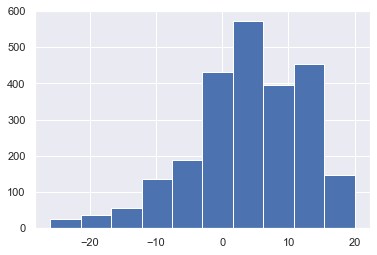

In [6]:
response_comp_df1["binary_vars"].hist()
plt.show()

In [7]:
response_comp_df1["DE_sum"].describe()

count    2447.000000
mean        0.585615
std         2.271244
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        42.000000
Name: DE_sum, dtype: float64

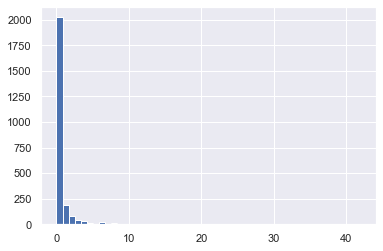

In [8]:
response_comp_df1["DE_sum"].hist(bins=50)
plt.show()

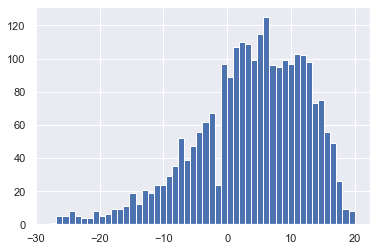

In [9]:
response_comp_df1["composite_conflict_score"].hist(bins=50)
plt.show()

In [10]:
(response_comp_df1["composite_conflict_score"]).to_csv("data/imputed_response_composite_iter1.csv")

In [27]:
response_comp_df1["composite_conflict_score"].isna().value_counts()

False    2447
Name: composite_conflict_score, dtype: int64

In [47]:
school_grouped_predictors = pd.get_dummies(original_sample[["SCHID","SCHTREAT","AGEC_NEW","GENDER",
                                "GR","COLL","CELL","FSCH"]],
               drop_first=True).groupby("SCHID",as_index=False).mean()
response_comp_df1["SCHID"] = original_sample["SCHID"]
school_grouped_response = pd.DataFrame(response_comp_df1.groupby("SCHID",as_index=False)["composite_conflict_score"].mean())

tenth_initial_df = school_grouped_predictors.merge(school_grouped_response)
tenth_initial_df.to_csv("data/sample_school_level_data.csv")
tenth_initial_df

,SCHID,AGEC_NEW,SCHTREAT_(1) Treatment school (Roots meetings 2012-2013),GENDER_(1) Boy,GR_(1) 6th grade,GR_(2) 7th grade,GR_(3) 8th grade,COLL_(1) Yes,COLL_(2) Maybe,COLL_(3) Don't know,CELL_(1) Cell phone without Internet,CELL_(2) Cell phone with Internet,FSCH_(1) Do go to this school,composite_conflict_score
0,1,12.296296,1.0,0.592593,0.222222,0.333333,0.333333,0.740741,0.111111,0.000000,0.370370,0.370370,0.703704,3.583333
1,2,11.750000,0.0,0.469388,0.224490,0.142857,0.367347,0.795918,0.102041,0.020408,0.204082,0.489796,0.775510,3.076531
2,3,12.500000,1.0,0.611111,0.000000,0.500000,0.500000,0.888889,0.111111,0.000000,0.333333,0.444444,0.944444,3.875000
3,5,12.666667,0.0,0.416667,0.000000,0.416667,0.416667,0.750000,0.083333,0.000000,0.166667,0.666667,0.750000,5.083333
4,6,12.550000,1.0,0.439024,0.000000,0.439024,0.414634,0.780488,0.073171,0.000000,0.365854,0.365854,0.756098,4.591463
5,7,12.192308,0.0,0.576923,0.288462,0.269231,0.442308,0.826923,0.096154,0.038462,0.519231,0.423077,0.942308,3.399038
6,8,11.733333,0.0,0.412698,0.253968,0.158730,0.285714,0.698413,0.126984,0.031746,0.396825,0.285714,0.619048,4.017857


In [51]:
student_lvl_predictors = pd.get_dummies(original_sample[["SCHID","SCHTREAT","AGEC_NEW",
                                                         "GENDER","GR","COLL","CELL","FSCH","TREAT"]])
student_lvl_predictors["Composite_Conflict_Score"] = response_comp_df1["composite_conflict_score"]
student_lvl_predictors.to_csv("data/sample_student_level_data.csv")
student_lvl_predictors.corr()

,SCHID,AGEC_NEW,SCHTREAT_(0) Control school (no Roots meetings 2012-2013),SCHTREAT_(1) Treatment school (Roots meetings 2012-2013),GENDER_(0) Girl,GENDER_(1) Boy,GR_(0) 5th grade,GR_(1) 6th grade,GR_(2) 7th grade,GR_(3) 8th grade,...,COLL_(3) Don't know,CELL_(0) No cell phone,CELL_(1) Cell phone without Internet,CELL_(2) Cell phone with Internet,FSCH_(0) Do not go to this school,FSCH_(1) Do go to this school,TREAT_(0) Not treatment or control,TREAT_(1) Treatment,TREAT_(2) Control,Composite_Conflict_Score
SCHID,1.000000,0.046447,-0.113729,0.122482,0.005247,0.003656,-0.002335,-0.061714,0.048459,0.018632,...,-0.008385,-0.027291,-0.006687,0.030312,-0.056779,0.034066,0.021575,0.015194,-0.023830,0.028069
AGEC_NEW,0.046447,1.000000,0.010971,-0.009949,-0.073741,0.041138,-0.525644,-0.487708,0.016494,0.688719,...,-0.032410,-0.161711,0.008721,0.089322,0.055087,-0.082142,-0.035978,-0.038679,0.018110,-0.043695
SCHTREAT_(0) Control school (no Roots meetings 2012-2013),-0.113729,0.010971,1.000000,-0.991041,-0.019136,0.034860,-0.022812,0.008141,-0.013824,0.036354,...,0.021509,0.008483,0.012665,0.010802,0.009861,0.025262,0.036363,-0.015079,-0.002249,-0.033037
SCHTREAT_(1) Treatment school (Roots meetings 2012-2013),0.122482,-0.009949,-0.991041,1.000000,0.017706,-0.034636,0.019227,-0.007079,0.012829,-0.035574,...,-0.019915,-0.007217,-0.015731,-0.010748,-0.012553,-0.021785,-0.035038,0.010873,0.001508,0.033037
GENDER_(0) Girl,0.005247,-0.073741,-0.019136,0.017706,1.000000,-0.875095,0.065989,0.023005,0.024875,0.050636,...,-0.023483,0.015760,0.041963,0.080933,0.023487,0.126898,0.139862,0.013197,0.010717,-0.040787
GENDER_(1) Boy,0.003656,0.041138,0.034860,-0.034636,-0.875095,1.000000,-0.027683,0.050319,0.065082,0.039583,...,0.047217,0.038057,0.045184,0.041737,0.019623,0.134610,0.117488,0.022236,0.022667,0.022794
GR_(0) 5th grade,-0.002335,-0.525644,-0.022812,0.019227,0.065989,-0.027683,1.000000,-0.157514,-0.193246,-0.193798,...,0.056353,0.142329,-0.045699,-0.059219,0.012876,0.039833,0.024330,0.023400,0.018158,-0.006537
GR_(1) 6th grade,-0.061714,-0.487708,0.008141,-0.007079,0.023005,0.050319,-0.157514,1.000000,-0.370013,-0.371070,...,0.003493,0.108254,-0.005040,-0.006839,-0.018304,0.084293,0.081170,0.030060,-0.013763,-0.000864
GR_(2) 7th grade,0.048459,0.016494,-0.013824,0.012829,0.024875,0.065082,-0.193246,-0.370013,1.000000,-0.455248,...,0.018335,-0.019784,0.090111,0.030649,-0.042596,0.139322,0.107954,0.002606,0.002112,0.024753
GR_(3) 8th grade,0.018632,0.688719,0.036354,-0.035574,0.050636,0.039583,-0.193798,-0.371070,-0.455248,1.000000,...,-0.028153,-0.102129,0.034398,0.141355,0.098204,0.042640,0.081196,-0.005204,0.035939,-0.036532


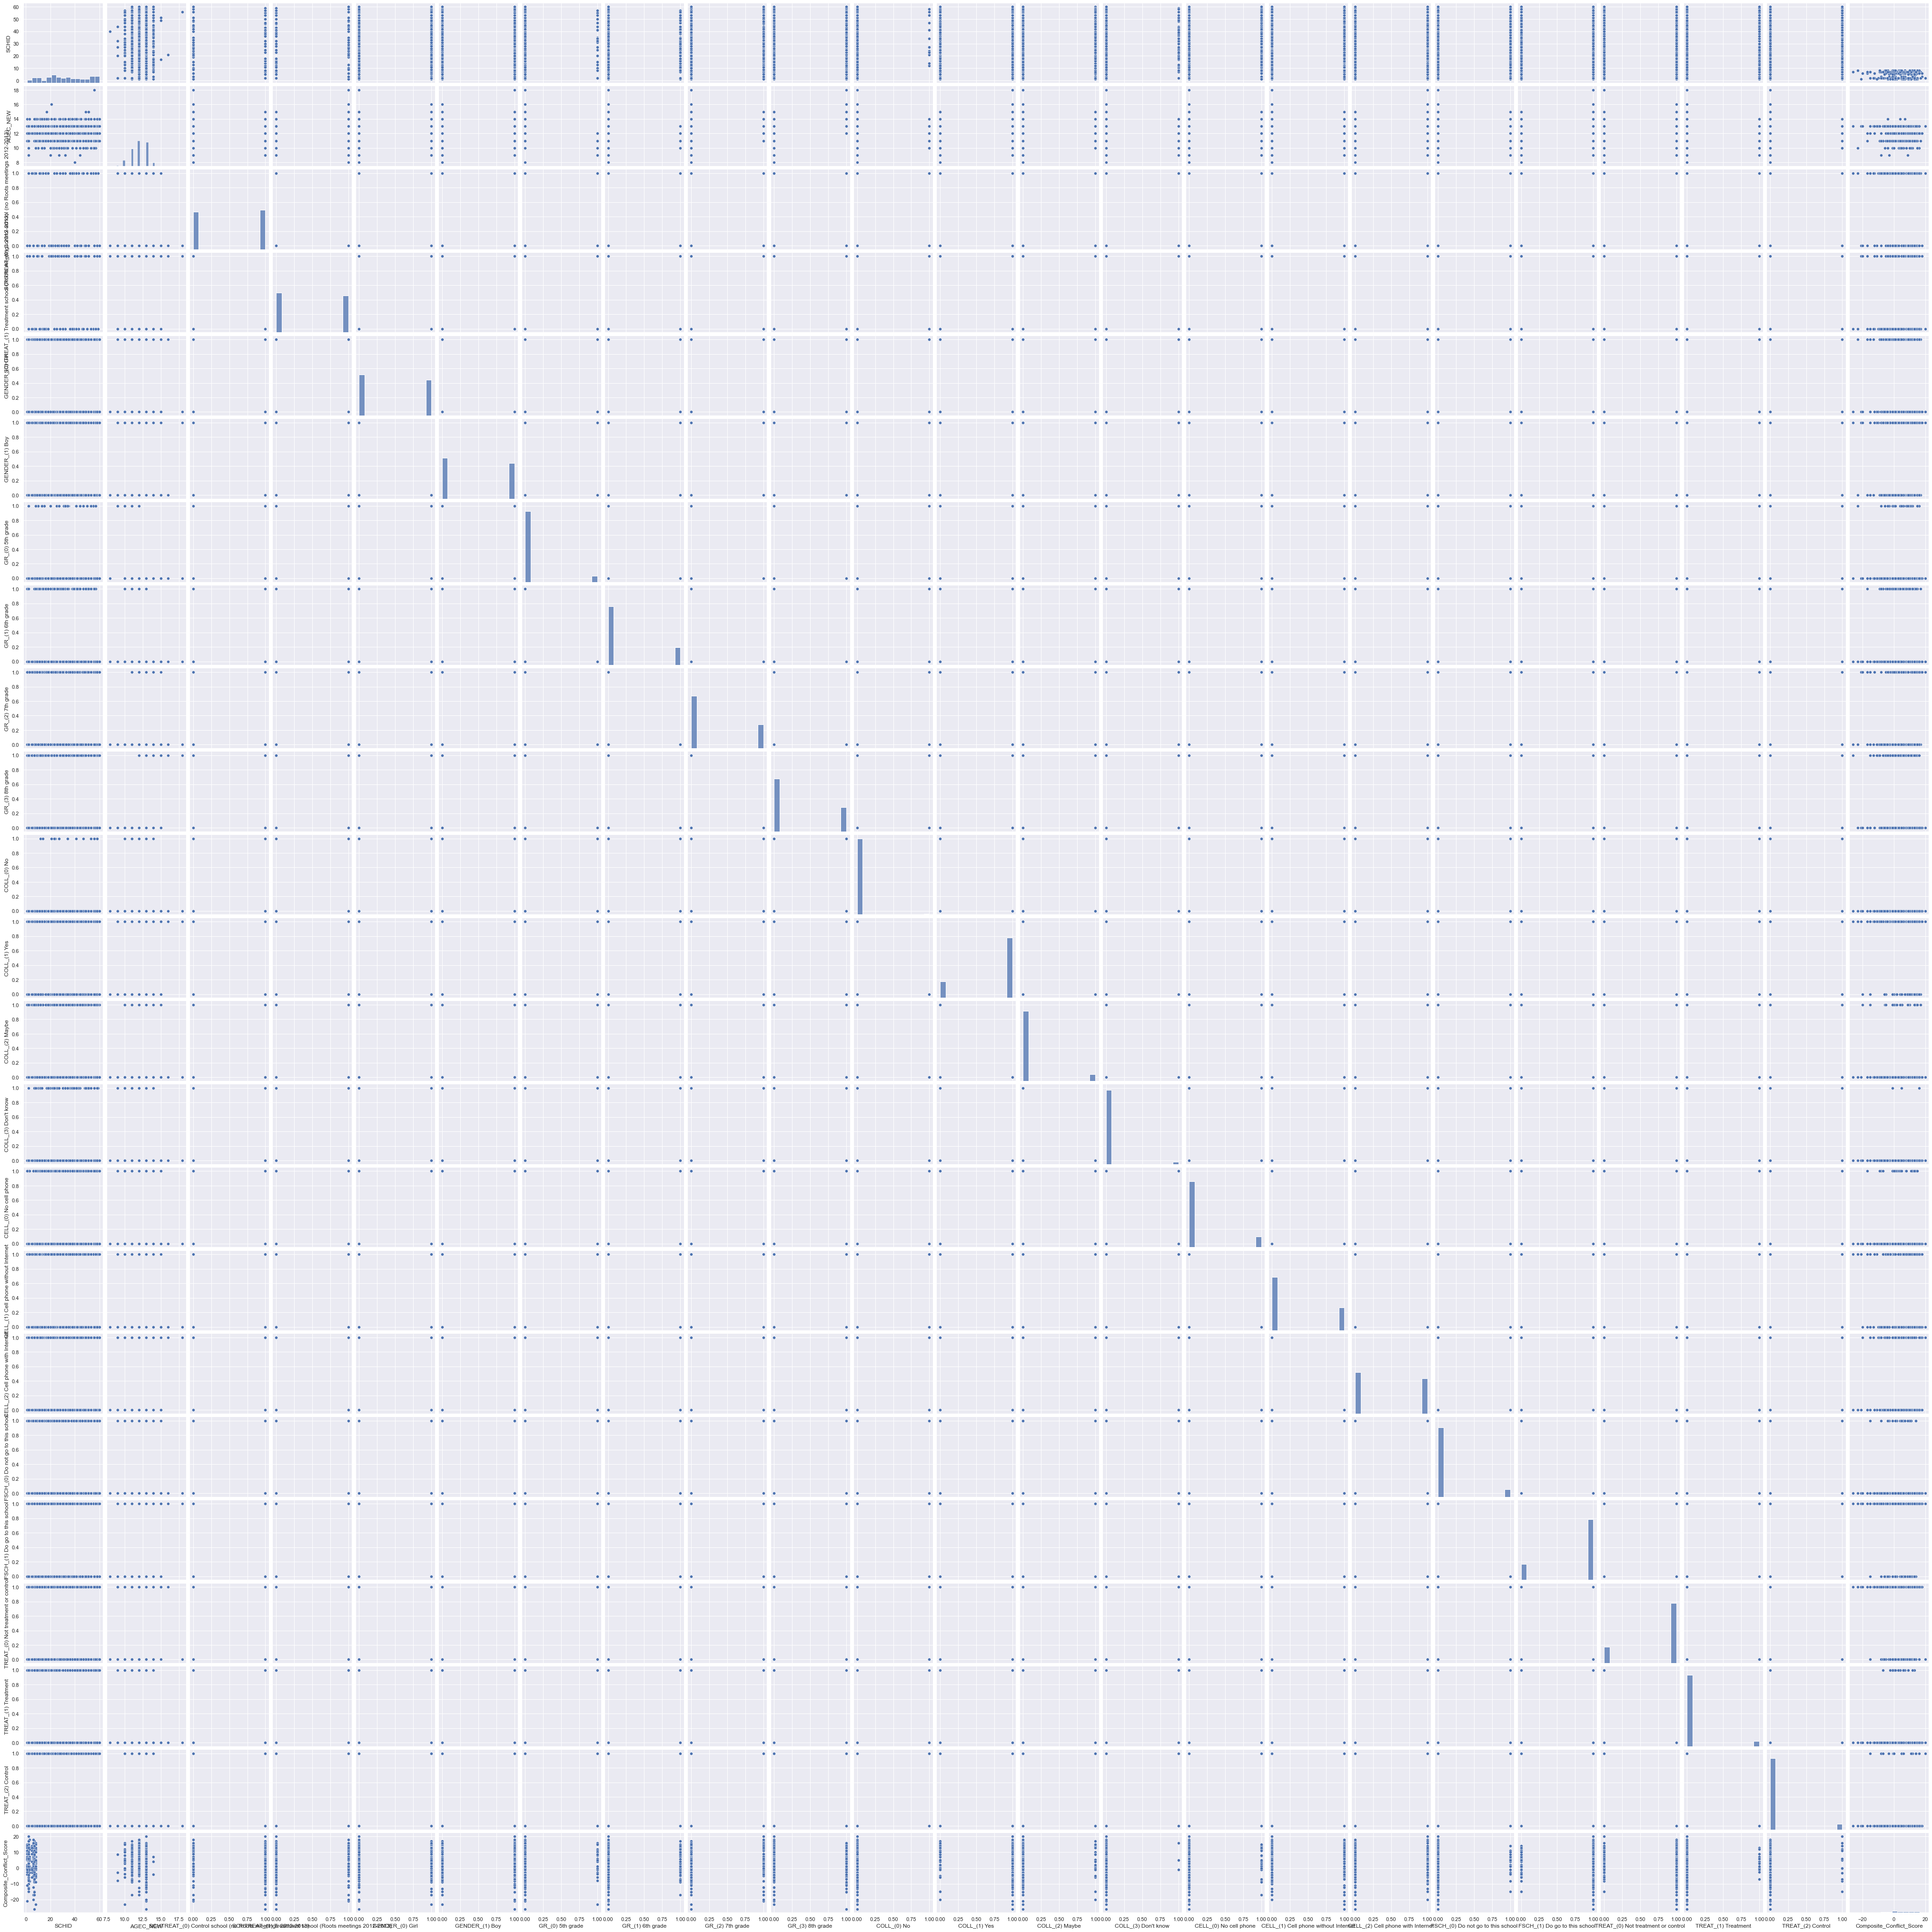

In [53]:
sns.pairplot(student_lvl_predictors)

In [12]:
predictor_comp_df1 = create_composite_vars(predictor_vars_df1)

KeyError: "None of [Index(['DNCL10W2_DUMMY1', 'DNCL11W2_DUMMY1', 'DNCL12W2_DUMMY1',\n       'PNCL1W2_DUMMY1', 'PNCL2W2_DUMMY1', 'PNCL7W2_DUMMY1', 'PNCL12W2_DUMMY1',\n       'PNCL13W2_DUMMY1', 'CSCAW2_DUMMY1', 'CLHCW2_DUMMY1', 'FLIHCW2_DUMMY1',\n       'TOMENW2_DUMMY1', 'TOMEPGW2_DUMMY1', 'TOMELNW2_DUMMY1',\n       'TOMESUW2_DUMMY1', 'TOMEHDW2_DUMMY1', 'DNCL9W2_DUMMY1',\n       'DNCL10W2_DUMMY1', 'DNCL11W2_DUMMY1', 'DNCL12W2_DUMMY1',\n       'CBNPW2_DUMMY1'],\n      dtype='object')] are in the [columns]"